# Binary classfication

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn import model_selection

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

### Home task: Spam detection

Для заданной тестовой выборки построить модель для предсказания является ли sms сообщение спамом.  
На заданном разбиении (df_train, df_test) ваша модель должна превзойти baseline'ы, приведенные ниже.  

Чем больше baseline'ов вы превзойдете, тем выше ваша оценка
Метрика качества F1


baseline 1: 0.9444      bag of words + Multinomial Naive Bayes  
baseline 2: 0.9490      symbol 3-grams with IDF and l2-norm + Logistic Regression  
baseline 3: 0.9636      text stemming + baseline 2  


! Your results must be reproducible. Если ваша модель - стохастическая (как например LogisticRegression), то вы явно должны задавать все seed и random_state в параметрах моделей  
! Вы должны использовать df_test только для измерения качества конечной обученной модели. 

In [2]:
#load dataset
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]
df = df.rename(columns={'v1': 'target', 'v2': 'text'})
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# dataset size
df.shape

(5572, 2)

In [4]:
# class proportions
df.target.value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: target, dtype: float64

In [5]:
# Use  df_train for model training
# Use df_test as  hold-out dataset for your final model perfomance estimation.
# You cannot change  this splitting
# All results must be reproducible
SEED = 1337
df_train, df_test = model_selection.train_test_split(df, test_size=0.4, random_state=SEED, shuffle=True, stratify=df.target)
print('train size %d, test size %d' % (df_train.shape[0], df_test.shape[0]))

train size 3343, test size 2229


In [26]:
#пробная версия модели

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV


# build binary feature matrix from BoW model
vec = TfidfVectorizer(lowercase=True, analyzer='word', ngram_range=(1,1), norm=None, use_idf=False, binary=True)
X = vec.fit_transform(df_train.text)
print('feature matrix shape', X.shape)


# encode class labels
label_enc = LabelEncoder().fit(df_train.target)
y_train = label_enc.transform(df_train.target)

# Logistic Regression classifier has several hyperparams
# Optimize C (coeff before regularizer) and penalty (type of regularizer) using crossvalidation with grid search
# Basically it means it will look over every combination of hyperparams in the specified region (or lattice)
# and return the best one. 
# Look in docs  for more details
grid = GridSearchCV(LogisticRegression(random_state=SEED), # our model 
                   param_grid={'C': np.logspace(0,5,20), # C in lattice [10^0...10^5]
                               'penalty': ['l1', 'l2']}, 
                    scoring='f1', # our perfomance measure 
                    n_jobs=-1, # multithread 
                    cv=5, # 5-fold stratified cross-validation 
                    verbose=True, return_train_score=True)

grid.fit(X, y_train)
print('best params', grid.best_params_)
print('best estimator', grid.best_score_)
model = grid.best_estimator_

# grid.best_estimator_ is already fitted on whole train dataset
print('train', metrics.f1_score(y_train, model.predict(X)))



X_test = vec.transform(df_test.text)
y_pred = model.predict(X_test)
y_test = label_enc.transform(df_test.target)
print('test', metrics.f1_score(y_test, model.predict(X_test)))

feature matrix shape (3343, 6629)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.2min finished


best params {'C': 100000.0, 'penalty': 'l2'}
best estimator 0.926911619472
train 1.0
test 0.938053097345


In [7]:
# baseline 1
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# build binary feature matrix from BoW model
vec = TfidfVectorizer(lowercase=True, analyzer='word', ngram_range=(1,1), norm=None, use_idf=False, binary=True)
X = vec.fit_transform(df_train.text)
print('feature matrix shape', X.shape)

# encode class labels
label_enc = LabelEncoder().fit(df_train.target)
y_train = label_enc.transform(df_train.target)

# fit our prediction model
model = MultinomialNB(alpha=1.0)
model.fit(X, y_train)
print('train', metrics.f1_score(y_train, model.predict(X)))

# perfomance on test dataset
X_test = vec.transform(df_test.text)
y_pred = model.predict(X_test)
y_test = label_enc.transform(df_test.target)
print('train', metrics.f1_score(y_test, model.predict(X_test)))

feature matrix shape (3343, 6629)
train 0.977477477477
train 0.944444444444


In [8]:
# baseline 2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV


# build feature matrix from 3-grams
# with l2-normalization and smoothed idf - look in docs for more details
vec = TfidfVectorizer(lowercase=True, analyzer='char', ngram_range=(3,3), norm='l2', use_idf=True, smooth_idf=True)
X = vec.fit_transform(df_train.text)
print('feature matrix shape', X.shape)

#encode labels
label_enc = LabelEncoder().fit(df_train.target)
y_train = label_enc.transform(df_train.target)

# Logistic Regression classifier has several hyperparams
# Optimize C (coeff before regularizer) and penalty (type of regularizer) using crossvalidation with grid search
# Basically it means it will look over every combination of hyperparams in the specified region (or lattice)
# and return the best one. 
# Look in docs  for more details
grid = GridSearchCV(LogisticRegression(random_state=SEED), # our model 
                   param_grid={'C': np.logspace(0,5,20), # C in lattice [10^0...10^5]
                               'penalty': ['l1', 'l2']}, 
                    scoring='f1', # our perfomance measure 
                    n_jobs=-1, # multithread 
                    cv=5, # 5-fold stratified cross-validation 
                    verbose=True, return_train_score=True)

grid.fit(X, y_train)
print('best params', grid.best_params_)
print('best estimator', grid.best_score_)
model = grid.best_estimator_

# grid.best_estimator_ is already fitted on whole train dataset
print('train', metrics.f1_score(y_train, model.predict(X)))

# perfomance on test dataset
X_test = vec.transform(df_test.text)
y_pred = model.predict(X_test)
y_test = label_enc.transform(df_test.target)
print('test', metrics.f1_score(y_test, model.predict(X_test)))

feature matrix shape (3343, 11830)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.2min finished


best params {'C': 54555.947811685146, 'penalty': 'l2'}
best estimator 0.946071242658
train 1.0
test 0.949033391916


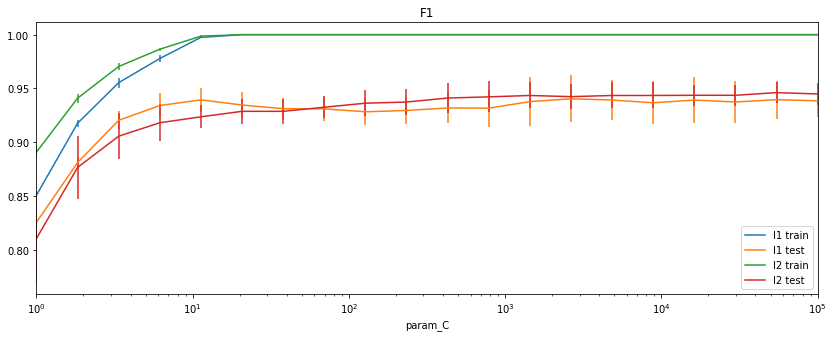

In [9]:
# validation curves
grid_df = pd.DataFrame(grid.cv_results_);
grid_df = grid_df[['param_C', 'param_penalty', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
fig, ax = plt.subplots(figsize=(14,5))
for label, df in grid_df.groupby('param_penalty'):
    df.plot(x='param_C', y='mean_train_score', yerr='std_train_score', logx=True, label=label + ' train',
            ax=ax)
    df.plot(x='param_C', y='mean_test_score', yerr='std_test_score', logx=True, label=label + ' test',
            ax=ax)
    plt.title('F1')

In [10]:
# baseline 3
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import string
import re


stemmer = SnowballStemmer("english")
regex = re.compile('[%s]' % re.escape(string.punctuation))

# basic preprocessing
# make lowercase, remove punctuation and make stemming
def text_process(text):
    text = text.lower()
    text = regex.sub(' ', text)
    text = [stemmer.stem(word) for word in text.split() if word not in stopwords.words('english')]
    return " ".join(text)


df_train['text2'] = df_train.text.apply(text_process)
df_test['text2'] = df_test.text.apply(text_process)
df_train.head()

# build feature matrix from 3-grams
vec = TfidfVectorizer(lowercase=True, analyzer='char', ngram_range=(3,3), 
                      min_df=10, # exclude 3-grams appeared in less then 10 messages. 
                      use_idf=True)
X = vec.fit_transform(df_train.text2)
print('feature matrix shape', X.shape)

#encode labels
label_enc = LabelEncoder().fit(df_train.target)
y_train = label_enc.transform(df_train.target)

# optimize  hyperparams
grid = GridSearchCV(LogisticRegression(random_state=SEED), 
                   param_grid={'C': np.logspace(0,5,10), 
                               'penalty': ['l1', 'l2']}, 
                    scoring='f1', n_jobs=-1, cv=5, verbose=True, return_train_score=True)

grid.fit(X, y_train)
print(grid.best_params_)
print(grid.best_score_)
model = grid.best_estimator_
print('train', metrics.f1_score(y_train, model.predict(X)))

X_test = vec.transform(df_test.text2)
y_pred = model.predict(X_test)
y_test = label_enc.transform(df_test.target)
print('test', metrics.f1_score(y_test, model.predict(X_test)))

feature matrix shape (3343, 2393)
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.7s finished


{'C': 100000.0, 'penalty': 'l2'}
0.944063297628
train 1.0
test 0.963604852686


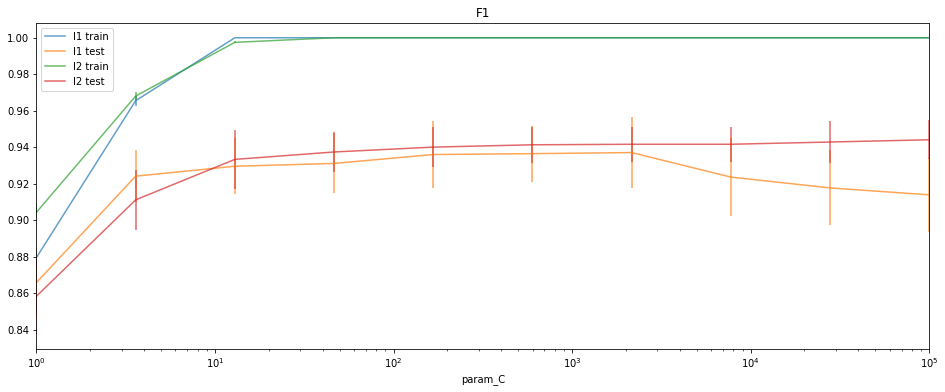

In [10]:
# validation curves
grid_df = pd.DataFrame(grid.cv_results_);
grid_df = grid_df[['param_C', 'param_penalty', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']]
fig, ax = plt.subplots(figsize=(16,6))
for label, df in grid_df.groupby('param_penalty'):
    df.plot(x='param_C', y='mean_train_score', yerr='std_train_score', logx=True, label=label + ' train',
            alpha=0.7,
            ax=ax)
    df.plot(x='param_C', y='mean_test_score', yerr='std_test_score', logx=True, label=label + ' test',
            alpha=0.7,
            ax=ax)
    plt.title('F1')